<a href="https://colab.research.google.com/github/ShamsulAbedin/CA684I/blob/master/Shamsul_Abedin_Malik_19215008_Predicting_Memorability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Media Memorability

As part of the assignment we are trying to build systems by applying different Machine learning Model and Features  that are capable to predict how memorable a video is, based on the calculation of the memorability score.

# This notebook is organized as follows:

* 1 [Loading Package & Libraries](#Section1)

* 2 [Function Definitions](#section2)

* 3 [Loading Video Memorabolity Files and Features](#section3)

* 4 [Data Preprocessing](#section4)

* 5 [Experiments with different Features and models](#section5)

* 6 [Determining the best model with features](#section6)

* 7 [Predicting the test Results](#section7)

* 8 [Reference](#section8)


# 1 : Loading Package & Libraries

## 1.1 : Installing packages

In [0]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 80kB/s 
     |████████████████████████████████| 491kB 43.5MB/s 
     |████████████████████████████████| 3.2MB 44.6MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, keras-applications, tensorflow-estimator, grpcio, protobuf, termcolor, tensorboard, numpy, gast, astor, absl-py, google-pasta, wrapt, keras-preprocessing, wheel
Required-by: fancyimpute


In [0]:
!pip install pyprind
!pip install keras

## 1.2 : Inporting Libraries

In [0]:
import pandas as pd

import numpy as np
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import glob
import nltk

In [0]:
from keras import Sequential
from keras import layers
from keras import regularizers
import tensorflow
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [0]:
# for reproducability
from numpy.random import seed
seed(1)

In [0]:
import tensorflow
from tensorflow import set_random_seed
tensorflow.set_random_seed(1)

# 2 :  FUNCTIONS DEFINITION

Here we are defining necessary functions required.

## 2.1 : C3D Feature

In [0]:
#Function to load C3D features
def read_C3D(df_caption, C3D_Path):
    files = list(df_caption["video"].values)
    C3D_Features = []
    for file in files:
        file = C3D_Path+file[:-4]+'txt'
        C3D_Features.append(np.loadtxt(file))
    #print(type(C3D_Features))
    return C3D_Features

## 2.2 : HMP features

In [0]:
#Function to load HMP features
def read_HMP(df_caption, HMP_Path):
    files = list(df_caption["video"].values)
    HMP_Features = []
    for file in files:
        file = HMP_Path+file[:-4]+'txt'
        with open(file) as f:
            for line in f:
                pairs=line.split()
                HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
                HMP = np.zeros(6075)
            for idx in HMP_temp.keys():
                HMP[idx-1] = HMP_temp[idx]
            HMP_Features.append(HMP)
    return HMP_Features

## 2.3 : Captions into dataframes

In [0]:
#Function to load the captions into dataframes
def read_caps(filename):
    video_name = []
    captions = []
    df_caption = pd.DataFrame()
    with open(filename) as file:
        for line in file:
            pair = line.split() #each line in the text file contains to words so, this code will split them into two words
            video_name.append(pair[0]) #first word will be assigned as video name
            captions.append(pair[1]) #second word will be assigned as caption
        df_caption['video']=video_name #setting these two as column names of dataframe
        df_caption['caption']=captions
    return df_caption


## 2.4 : Spearman coefficient scores

In [0]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# 3 : Loading Video Memorability files and Features

## 3.1 : Mounting Drive

In [0]:
import os
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 3.2 : Loading Features

In [0]:
#load the ground truth dataset
path_label = '/content/drive/My Drive/CA684_Assignment/Dev-set/Ground-truth/'
labels=pd.read_csv(path_label+'ground-truth.csv')

In [0]:
#load captions
caption_path='/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
df_caption=read_caps(caption_path)

In [0]:
#load C3D features
C3D_Path = '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/'
C3D_Features = read_C3D(df_caption,C3D_Path)

In [0]:
#load HMP features
HMP_Path = '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/'
HMP_Features = read_HMP(df_caption,HMP_Path)

In [0]:
print(df_caption)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
...              ...                                                ...
5995  video7488.webm        beautiful-young-woman-in-front-of-fountains
5996  video7489.webm  focus-pull-from-molting-penguin-to-penguin-col...
5997  video7491.webm           students-walking-in-university-of-mexico
5998  video7492.webm                       beautiful-black-woman-at-spa
5999  video7493.webm  beautiful-modern-brunette-woman-using-tablet-c...

[6000 rows x 2 columns]


In [0]:
#shape of the dataframes
print(f'Ground Truth : {labels.shape}')
print(f'Dev Captions : {df_caption.shape}')
print(f'C3D          : ({len(C3D_Features)})')
print(f'HMP          : ({len(HMP_Features)})')

Ground Truth : (6000, 5)
Dev Captions : (6000, 2)
C3D          : (6000)
HMP          : (6000)


## 3.3 : Joining the dataframes

In [0]:
df = df_caption.merge(labels,on=["video"],how="inner")
df

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10
...,...,...,...,...,...,...
5995,video7488.webm,beautiful-young-woman-in-front-of-fountains,0.921,33,1.000,9
5996,video7489.webm,focus-pull-from-molting-penguin-to-penguin-col...,0.909,53,0.839,31
5997,video7491.webm,students-walking-in-university-of-mexico,0.713,33,0.818,11
5998,video7492.webm,beautiful-black-woman-at-spa,0.954,34,1.000,16


# 4 : Data Preprocessing

## 4.1 : Captions: Bag of words CountVectorizer

In [0]:
import nltk
nltk.download('stopwords')

#loading the nltk stopwords of English
stopwords = nltk.corpus.stopwords.words('english')
print(f'Length of Stopwords: {len(stopwords)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Length of Stopwords: 179


In [0]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_caption['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_caption['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    df_caption.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()


Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [0]:
df_caption.head()

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot


In [0]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
captions_bag = vectorizer.fit_transform(df_caption.caption).toarray()
type(captions_bag)

numpy.ndarray

In [0]:
captions_bag.shape

(6000, 3112)

## 4.2 : Combining Captions and C3D into a single Vector

In [0]:
captions_c3d = (captions_bag.tolist())
counter = 0
for item in range(6000):
    captions_c3d[counter] = np.append(captions_c3d[counter],C3D_Features[counter],axis=0)
    counter = counter+1

In [0]:
len(captions_c3d[0]) 

3213

In [0]:
len(captions_c3d)

6000

## 4.3 : Combining Captions+C3D+HMP

In [0]:
#Combining captions_c3d with HMP to form 
captions_c3d_hmp = captions_c3d
counter = 0
for item in range(6000):
    captions_c3d_hmp[counter] = np.append(captions_c3d_hmp[counter],HMP_Features[counter],axis=0)
    counter = counter+1

In [0]:
len(captions_c3d_hmp[0]) 

9288

In [0]:
len(captions_c3d_hmp)

6000

Now we have the following features

1.   Captions in: captions_bag
2.   C3D in: c3dfeatures 
3.   HMP in: hmp_features
4.   Captions and C3D:&nbsp;  captions_c3d
5.   Captions, C3D and HMP in: captions_c3d_hmp

# 5 : Experiments with different features and models

## 5.1: Random Forest  with Captions

In [0]:
X = captions_bag
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100,random_state=45)

In [0]:
captions_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

In [0]:
captions_pred = captions_rf.predict(X_test)

In [0]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.409
The Spearman's correlation coefficient is: 0.176


***

## 5.2: SVR with Captions

In [0]:
svr_X = captions_bag
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.338
The Spearman's correlation coefficient is: 0.170


***
<a id='section4.3'></a>

## 5.3: Random Forest with C3D

In [0]:
X = C3D_Features
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=20,random_state=42,verbose=2)

In [0]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [0]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [0]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.266
The Spearman's correlation coefficient is: 0.122


***
<a id='section4.4'></a>

## 5.4: SVR with C3D

In [0]:
svr_X = C3D_Features
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.355
The Spearman's correlation coefficient is: 0.179


***
<a id='section4.5'></a>

## 5.5: Random Forest with Captions and C3D

In [0]:
X = captions_c3d
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=50,random_state=45,verbose=2)

In [0]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 15.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [0]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [0]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.300
The Spearman's correlation coefficient is: 0.120


***
<a id='section4.6'></a>

## 5.6: SVR with Captions and C3D

In [0]:
svr_X = captions_c3d
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.355
The Spearman's correlation coefficient is: 0.179


***
<a id='section4.7'></a>

## 5.7: Random Forest with Captions, C3D and HMP

In [0]:
X = captions_c3d_hmp
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45,verbose=2)

In [0]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 29.4min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [0]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [0]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.322
The Spearman's correlation coefficient is: 0.145


***
<a id='section4.8'></a>

## 5.8: SVR with Captions, C3D and HMP

In [0]:
svr_X = captions_c3d_hmp
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.355
The Spearman's correlation coefficient is: 0.179


***
<a id='section5'></a>

# 6 : Determining the best model with features

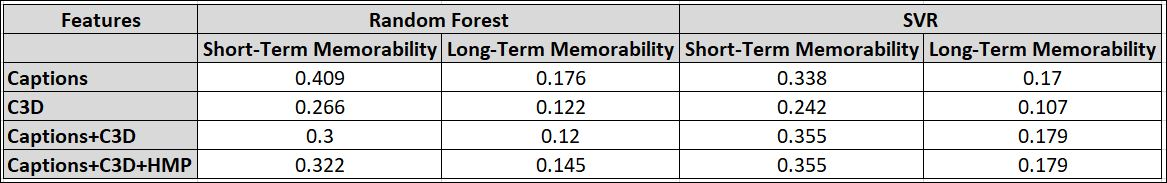

In [0]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Memorability.JPG",width="800",height="250")

The above table represents the spearman correlation coefficient scores for different features and models. It is noticeable from the above table that Random forest comparably has better performance.

In [0]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.409
The Spearman's correlation coefficient is: 0.176


***
<a id='section7'></a>

# 7 : Predicting the test Results

In the above Random Forest with Captions model, We had divided our development dataset for training and testing. In order to predict the test results, we need to train our model for full 6000 Development dataset. 

In the Below lines of code, we will be using full 6000 records of development datatset to train our model and predict the scores on testing set which has 2000 records.

## 7.1: Training on full Dev-Set

we have trained our model for full 6000 Dev-set using Random Forest Regressor

In [0]:
X = captions_bag
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
print(f'X: ({len(X)})')
print(f'y:{y.shape}')

X: (6000)
y:(6000, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45)

In [0]:
rf_regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

### 7.2: Importing Test Dataset and Captions

In [0]:
#importing test Dataset
csv_path ='/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
test_dataset = pd.read_csv(csv_path)

In [0]:
#load the test set captions
test_captions_path ='/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
test_captions = read_caps(test_captions_path)

In [0]:
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


We need to predict and fill the values of the above Short-term Memorability and Long-term Memorability Scores using our trained model

In [0]:
test_captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [0]:
#printing the dimensions of test-set dataset and features
print(f'Test-Dataset : {test_dataset.shape}')
print(f'Test-Captions: {test_captions.shape}')

Test-Dataset : (2000, 5)
Test-Captions: (2000, 2)


In [0]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(test_captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(test_captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    test_captions.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [0]:
test_captions.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


In [0]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
test_captions_bag = vectorizer.fit_transform(test_captions.caption).toarray()
type(test_captions_bag)

numpy.ndarray

In [0]:
print(f'Development Vocabulary Size   : {len(captions_bag[0])}')
print(f'Testing Vocabulary Size       : {len(test_captions_bag[0])}')

Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


***
<a id='section7.3'></a>

## 7.3: Predicting the scores and Exporting the Results

In [0]:
test_prediction = rf_regressor.predict(test_captions_bag)

In [0]:
prediction_score = pd.DataFrame()

In [0]:
type(test_prediction)

numpy.ndarray

In [0]:
prediction_score['short-term'] = test_prediction[:,0]

In [0]:
prediction_score['long-term'] = test_prediction[:,1]

In [0]:
prediction_score.head()

,short-term,long-term
0,0.854635,0.712699
1,0.898883,0.781500
2,0.841901,0.805625
3,0.915282,0.826990
4,0.866134,0.711727


In [0]:
prediction_score.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.848028,0.751163
std,0.034564,0.067863
min,0.687093,0.397318
25%,0.830368,0.721224
50%,0.849698,0.757218
75%,0.871004,0.792872
max,0.953749,0.949478


In [0]:
prediction_score.to_csv("/content/drive/My Drive/Shamsul_Abedin_malik_19215008_Prediction.csv",index=False)

***

# 8 : Reference



> 1: http://ceur-ws.org/Vol-2283/MediaEval_18_paper_1.pdf

> 2: https://www.kaggle.com/jagajithmk/mediaeval-2018-predicting-media-memorability 

> 3: https://github.com/Alekhya-Singh/Predicting-Video-Memorability-Score/blob/master/MediaEval_Memorability_Prediction_with_Captions.ipynb

